In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import arch
from arch.unitroot import ADF
from arch import arch_model
import matplotlib.pyplot as plt
import datetime

In [2]:
seel = yf.download(tickers="SEEL", period="7d", interval="1m")
zyne = yf.download(tickers="ZYNE", period="7d", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
seel_adf = ADF(seel["Close"])
print(seel_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.139
P-value                         0.699
Lags                               25
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [4]:
zyne_adf = ADF(zyne["Close"])
print(zyne_adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.950
P-value                         0.309
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [5]:
zyne_returns = 100 * (zyne["Close"].pct_change().dropna())
zyne_arch = arch_model(zyne_returns, dist="skewt")
zyne_res = zyne_arch.fit()
print(zyne_res.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 412.25060912046354
Iteration:      2,   Func. Count:     18,   Neg. LLF: 412.2152827223017
Iteration:      3,   Func. Count:     29,   Neg. LLF: 412.1765534570088
Iteration:      4,   Func. Count:     39,   Neg. LLF: 412.10377959838297
Iteration:      5,   Func. Count:     48,   Neg. LLF: 412.06137308880886
Iteration:      6,   Func. Count:     57,   Neg. LLF: 412.0037286793126
Iteration:      7,   Func. Count:     67,   Neg. LLF: 411.97997038753874
Iteration:      8,   Func. Count:     76,   Neg. LLF: 411.9685836920337
Iteration:      9,   Func. Count:     84,   Neg. LLF: 411.93271902598485
Iteration:     10,   Func. Count:     92,   Neg. LLF: 411.9145852056912
Iteration:     11,   Func. Count:    100,   Neg. LLF: 411.9048739350483
Iteration:     12,   Func. Count:    108,   Neg. LLF: 411.9045583172682
Iteration:     13,   Func. Count:    116,   Neg. LLF: 411.90455127888055
Optimization terminated successfully.    (Exit mode 0)
   

In [6]:
zyne[-117:]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-04-14 09:30:00-04:00,1.7800,1.7800,1.7700,1.7700,1.7700,3267
2022-04-14 09:36:00-04:00,1.7600,1.7700,1.7600,1.7600,1.7600,7380
2022-04-14 09:37:00-04:00,1.7600,1.7600,1.7500,1.7500,1.7500,2123
2022-04-14 09:38:00-04:00,1.7450,1.7500,1.7436,1.7436,1.7436,900
2022-04-14 09:39:00-04:00,1.7500,1.7500,1.7500,1.7500,1.7500,1300
...,...,...,...,...,...,...
2022-04-14 15:56:00-04:00,1.7210,1.7210,1.7200,1.7200,1.7200,910
2022-04-14 15:57:00-04:00,1.7285,1.7285,1.7285,1.7285,1.7285,158
2022-04-14 15:58:00-04:00,1.7200,1.7250,1.7200,1.7250,1.7250,1541


C:\Users\Michael\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Michael\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


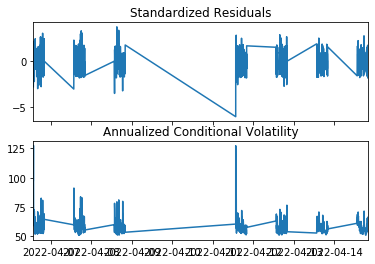

In [7]:
fig = zyne_res.plot(scale=252*120)

In [8]:
zyne_res.conditional_volatility

Datetime
2022-04-06 09:31:00-04:00    0.561956
2022-04-06 09:34:00-04:00    0.682392
2022-04-06 09:36:00-04:00    0.733078
2022-04-06 09:37:00-04:00    0.625374
2022-04-06 09:38:00-04:00    0.544945
                               ...   
2022-04-14 15:56:00-04:00    0.382636
2022-04-14 15:57:00-04:00    0.352803
2022-04-14 15:58:00-04:00    0.367084
2022-04-14 15:59:00-04:00    0.346847
2022-04-14 16:00:00-04:00    0.339403
Name: cond_vol, Length: 1260, dtype: float64

In [9]:
zyne_forecasts = zyne_res.forecast(reindex=False)
print(zyne_forecasts.mean.iloc[-3:])
print(zyne_forecasts.residual_variance.iloc[-3:])
print(zyne_forecasts.variance.iloc[-3:])

                                h.1
Datetime                           
2022-04-14 16:00:00-04:00 -0.009247
                                h.1
Datetime                           
2022-04-14 16:00:00-04:00  0.136057
                                h.1
Datetime                           
2022-04-14 16:00:00-04:00  0.136057


In [10]:
zyne_forecasts.variance["h.1"][0]

0.1360568071383528

In [11]:
np.sqrt(0.136057)

0.3688590516715023

In [12]:
def next_min_bound(ticker, st_devs):
    today = datetime.datetime.now()
    four = (today - datetime.timedelta(days = 28)).date().strftime("%Y-%m-%d")
    three = (today - datetime.timedelta(days = 21)).date().strftime("%Y-%m-%d")
    two = (today - datetime.timedelta(days = 14)).date().strftime("%Y-%m-%d")
    one = (today - datetime.timedelta(days = 7)).date().strftime("%Y-%m-%d")
    t43 = yf.download(tickers=ticker, start=four, end=three, interval="1m")
    t32 = yf.download(tickers=ticker, start=three, end=two, interval="1m")
    t21 = yf.download(tickers=ticker, start=two, end=one, interval="1m")
    t10 = yf.download(tickers=ticker, period="7d", interval="1m")
    ticker = pd.concat([t43, t32, t21, t10])
    adf = ADF(ticker["Close"])
    print(adf.summary().as_text())
    returns = 100 * (ticker["Close"].pct_change().dropna())
    arch = arch_model(returns, dist="skewt")
    result = arch.fit()
    print(result.summary())
    print(result.conditional_volatility)
    var = result.forecast(reindex=False).variance["h.1"][0]
    return np.sqrt(var)*st_devs

In [25]:
def full_month(ticker):
    today = datetime.datetime.now()
    four = (today - datetime.timedelta(days = 28)).date().strftime("%Y-%m-%d")
    three = (today - datetime.timedelta(days = 21)).date().strftime("%Y-%m-%d")
    two = (today - datetime.timedelta(days = 14)).date().strftime("%Y-%m-%d")
    one = (today - datetime.timedelta(days = 7)).date().strftime("%Y-%m-%d")
    t43 = yf.download(tickers=ticker, start=four, end=three, interval="1m")
    t32 = yf.download(tickers=ticker, start=three, end=two, interval="1m")
    t21 = yf.download(tickers=ticker, start=two, end=one, interval="1m")
    t10 = yf.download(tickers=ticker, period="7d", interval="1m")
    ticker = pd.concat([t43, t32, t21, t10])
    return ticker

In [32]:
def adf_full_month(ticker):
    tick = full_month(ticker)
    adf = ADF(tick["Close"])
    print(adf.summary().as_text())

In [33]:
def conditional_vol(ticker):
    ticker = full_month(ticker)
    returns = 10000 * (ticker["Close"].pct_change().dropna())
    arch = arch_model(returns, dist="skewt")
    result = arch.fit()
    return ticker, returns, result.conditional_volatility

In [15]:
sedg, sedg_returns, sedg_vol = conditional_vol("SEDG")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 34305.68844332429
Iteration:      2,   Func. Count:     17,   Neg. LLF: 34165.03670564797
Iteration:      3,   Func. Count:     26,   Neg. LLF: 34037.9248084382
Iteration:      4,   Func. Count:     35,   Neg. LLF: 33980.21796629872
Iteration:      5,   Func. Count:     44,   Neg. LLF: 33948.6100255655
Iteration:      6,   Func. Count:     53,   Neg. LLF: 33908.42969676745
Iteration:      7,   Func. Count:     62,   Neg. LLF: 33886.08456557094
Iteration:      8,   Func. Count:     71,   Neg. LLF: 33880.61783439186
Iteration:      9,   Func. Count:     80,   Neg. LLF: 33866.86790758035
Iteration:     10,   Func. Count:     89,   Neg. LLF: 33857.352697859256
Itera

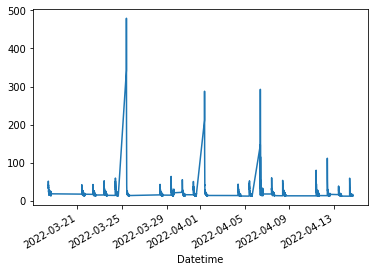

In [52]:
sedg_vol.plot()

In [16]:
enph, enph_returns, enph_vol = conditional_vol("ENPH")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 36293.21323655884
Iteration:      2,   Func. Count:     17,   Neg. LLF: 36190.88333292195
Iteration:      3,   Func. Count:     26,   Neg. LLF: 36153.25057530614
Iteration:      4,   Func. Count:     36,   Neg. LLF: 36107.08232563971
Iteration:      5,   Func. Count:     45,   Neg. LLF: 36084.065353748425
Iteration:      6,   Func. Count:     54,   Neg. LLF: 35996.983564349954
Iteration:      7,   Func. Count:     63,   Neg. LLF: 35962.80161608458
Iteration:      8,   Func. Count:     72,   Neg. LLF: 35952.510680835025
Iteration:      9,   Func. Count:     81,   Neg. LLF: 35935.04462905986
Iteration:     10,   Func. Count:     90,   Neg. LLF: 35923.77361133972
I

In [17]:
sedg_differential = sedg_returns + sedg_vol
sedg_times = sedg_differential[sedg_differential < 0].reset_index()

In [18]:
enph = enph.reset_index().reset_index()

In [19]:
for i in range(1, 30):
    trimmed = enph[:-i]
    entries = trimmed.loc[trimmed["Datetime"].isin(sedg_times["Datetime"])].reset_index(drop=True)
    sell = enph.loc[enph["index"].isin(entries["index"] + i)]
    profit = sum(sell["Close"]) - sum(entries["Close"])
    print(profit)

-20.163177490234375
-27.245925903320312
-47.29518127441406
-55.383056640625
-35.91468811035156
-33.0103759765625
12.236160278320312
20.177154541015625
12.536483764648438
19.896820068359375
26.451492309570312
23.829559326171875
64.15934753417969
55.27467346191406
54.73033142089844
40.13792419433594
53.55064392089844
72.99017333984375
59.763458251953125
84.18247985839844
79.79423522949219
90.26605224609375
90.35267639160156
92.72198486328125
89.61625671386719
112.12388610839844
77.73460388183594
84.59832763671875
87.03530883789062


In [20]:
def t1_to_t2_test(ticker1, ticker2, window):
    t1, t1_returns, t1_vol = conditional_vol(ticker1)
    t2, t2_returns, t2_vol = conditional_vol(ticker2)
    t1_diff = t1_returns + t1_vol
    t1_times = t1_diff[t1_diff < 0].reset_index()
    t2 = t2.reset_index().reset_index()
    for i in range(1, window + 1):
        trimmed = t2[:-i]
        entries = trimmed.loc[trimmed["Datetime"].isin(t1_times["Datetime"])].reset_index(drop=True)
        sell = t2.loc[t2["index"].isin(entries["index"] + i)]
        profit = sum(sell["Close"]) - sum(entries["Close"])
        print(f"{profit} profit when held for {i} minutes")

In [56]:
adf_full_month("ENPH")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.387
P-value                         0.145
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [21]:
t1_to_t2_test("SEDG", "ENPH", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 34305.68844332429
Iteration:      2,   Func. Count:     17,   Neg. LLF: 34165.03670564797
Iteration:      3,   Func. Count:     26,   Neg. LLF: 34037.9248084382
Iteration:      4,   Func. Count:     35,   Neg. LLF: 33980.21796629872
Iteration:      5,   Func. Count:     44,   Neg. LLF: 33948.6100255655
Iteration:      6,   Func. Count:     53,   Neg. LLF: 33908.42969676745
Iteration:      7,   Func. Count:     62,   Neg. LLF: 33886.08456557094
Iteration:      8,   Func. Count:     71,   Neg. LLF: 33880.61783439186
Iteration:      9,   Func. Count:     80,   Neg. LLF: 33866.86790758035
Iteration:     10,   Func. Count:     89,   Neg. LLF: 33857.352697859256
Itera

In [28]:
ctva = full_month("CTVA")
ctva_adf = ADF(ctva["Close"])
print(ctva_adf.summary().as_text())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -1.972
P-value                         0.299
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [22]:
t1_to_t2_test("NTR", "CTVA", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 33040.277294499276
Iteration:      2,   Func. Count:     17,   Neg. LLF: 32739.429706431867
Iteration:      3,   Func. Count:     26,   Neg. LLF: 32238.41673098256
Iteration:      4,   Func. Count:     35,   Neg. LLF: 31932.372890051814
Iteration:      5,   Func. Count:     44,   Neg. LLF: 31650.702721957026
Iteration:      6,   Func. Count:     53,   Neg. LLF: 31452.298447612728
Iteration:      7,   Func. Count:     62,   Neg. LLF: 31330.612522161333
Iteration:      8,   Func. Count:     71,   Neg. LLF: 31169.62648162135
Iteration:      9,   Func. Count:     80,   Neg. LLF: 31107.34212619415
Iteration:     10,   Func. Count:     89,   Neg. LLF: 31062.6038440509

In [24]:
t1_to_t2_test("CTVA", "NTR", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 28610.55858798039
Iteration:      2,   Func. Count:     17,   Neg. LLF: 28407.4874975405
Iteration:      3,   Func. Count:     27,   Neg. LLF: 28307.1345133939
Iteration:      4,   Func. Count:     36,   Neg. LLF: 28269.43526166891
Iteration:      5,   Func. Count:     45,   Neg. LLF: 28253.518659349338
Iteration:      6,   Func. Count:     54,   Neg. LLF: 28245.435183161328
Iteration:      7,   Func. Count:     63,   Neg. LLF: 28234.59254401934
Iteration:      8,   Func. Count:     72,   Neg. LLF: 28217.375838440377
Iteration:      9,   Func. Count:     81,   Neg. LLF: 28197.042604513605
Iteration:     10,   Func. Count:     90,   Neg. LLF: 28173.54358035159
It

In [29]:
t1_to_t2_test("ADM", "BG", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 29224.514642360453
Iteration:      2,   Func. Count:     17,   Neg. LLF: 28886.220040514083
Iteration:      3,   Func. Count:     26,   Neg. LLF: 28542.51632757315
Iteration:      4,   Func. Count:     35,   Neg. LLF: 28505.400570411246
Iteration:      5,   Func. Count:     44,   Neg. LLF: 28461.415285680123
Iteration:      6,   Func. Count:     53,   Neg. LLF: 28447.497460784933
Iteration:      7,   Func. Count:     62,   Neg. LLF: 28418.423424241348
Iteration:      8,   Func. Count:     71,   Neg. LLF: 28399.857865735506
Iteration:      9,   Func. Count:     80,   Neg. LLF: 28374.619053245868
Iteration:     10,   Func. Count:     89,   Neg. LLF: 28362.03976915

In [30]:
t1_to_t2_test("BG", "ADM", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 31788.955238692568
Iteration:      2,   Func. Count:     17,   Neg. LLF: 31449.334503615195
Iteration:      3,   Func. Count:     26,   Neg. LLF: 30839.24970255004
Iteration:      4,   Func. Count:     35,   Neg. LLF: 30430.69799021235
Iteration:      5,   Func. Count:     44,   Neg. LLF: 30081.511132720345
Iteration:      6,   Func. Count:     53,   Neg. LLF: 29694.276311541973
Iteration:      7,   Func. Count:     62,   Neg. LLF: 29465.92910297973
Iteration:      8,   Func. Count:     71,   Neg. LLF: 29276.526735234656
Iteration:      9,   Func. Count:     80,   Neg. LLF: 29123.559682039166
Iteration:     10,   Func. Count:     89,   Neg. LLF: 29026.1660078535

In [45]:
adf_full_month("AMRS")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.014
P-value                         0.034
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [48]:
t1_to_t2_test("AMRS", "MGPI", 30)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 37440.01328062146
Iteration:      2,   Func. Count:     19,   Neg. LLF: 37437.94152055419
Iteration:      3,   Func. Count:     29,   Neg. LLF: 37432.32496325839
Iteration:      4,   Func. Count:     39,   Neg. LLF: 37430.367445194825
Iteration:      5,   Func. Count:     49,   Neg. LLF: 37427.13393308478
Iteration:      6,   Func. Count:     59,   Neg. LLF: 37426.84938442754
Iteration:      7,   Func. Count:     68,   Neg. LLF: 37425.904141087754
Iteration:      8,   Func. Count:     77,   Neg. LLF: 37424.01882654636
Iteration:      9,   Func. Count:     85,   Neg. LLF: 37423.57543640458
Iteration:     10,   Func. Count:     93,   Neg. LLF: 37423.539463282905
I